In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Part 0: Basic definitions and utilities

This part defines a simple "grid world" MDP with the following rules:
* The state space is an M by N grid, giving a total of X = N*M states
* There are A=4 actions corresponding to going up, right, down, left
* Each action is successful with probability p; in case of failure, the agent moves in a random direction
* The reward function only depends on the state and is given by the M by N array "reward"
* There are some obstacles where the agent is not allowed to step; these are represented by 1s in the binary array "obstacles"
* The discount factor is gamma

The following code defines the transition matrix P and the reward vector r represented by an X times X times A matrix and an X-sized vector.

In [2]:
### basic properties of the MDP: size, transition probabilities
N = 10  # x-dimension
M = 10  # y-dimension
X = N*M # number of states
A = 4   # number of actions
p = .6  # success probability
q = (1-p)/3

### obstacles and rewards; agent cannot step on obstacles
obstacles = np.zeros((M,N)) # easy MDP: no obstacles
obstacles[1:5,4] = 1        # hard MDP 1: one wall 
obstacles[5,2:5] = 1        # hard MDP 2: two walls
reward = np.zeros((M,N))
reward[3,3] = 1
reward[4,7] = .9
reward[5,5] = -.5
gamma = .99

In [3]:
# utilities
    
def scalarize(m,n,M,N): # turns a pair of (m,n) coordinates into a flat 1-dimensional representation x
    x = N*m + n
    return x

def vectorize(x,M,N): # turns a flat 1-dimensional representation x into a pair of (m,n) coordinates
    n = np.mod(x,N)
    m = (x-n)//N
    return (m,n)

def move(m,n,delta_m,delta_n,M,N,obstacles): # from a given grid position (m,n), move in direction (delta_m,delta_n) if possible
    mtr = np.maximum(np.minimum(m+delta_m,M-1),0)
    ntr = np.maximum(np.minimum(n+delta_n,N-1),0)
    if obstacles[mtr,ntr]==1:
        return scalarize(m,n,M,N)
    else:
        return scalarize(mtr,ntr,M,N)
    
def vector_to_matrix(value_vector,M,N): # turns a function on the state space represented as a flat X-dimensional vector to an M by N matrix
    X = N*M
    value_matrix = np.zeros((M,N))
    for x in range(0,X):
        [m,n] = vectorize(x,M,N)
        value_matrix[m,n] = value_vector[x]
        if obstacles[m,n]==1:
            value_matrix[m,n]=np.nan
    return value_matrix

def matrix_to_vector(value_matrix): # turns a function on the state space represented as an M by N matrix into a flat X-dimensional vector
    [M,N] = [np.size(value_matrix,0),np.size(value_matrix,1)]
    X = N*M
    value_vector = np.zeros((X))
    for x in range(0,X):
        [m,n] = vectorize(x,M,N)
        value_vector[x] = value_matrix[m,n]
    return value_vector

In [4]:
# constructs a transition model P for gridworld environment with size (M,N) and obstacles specified in a binary array
# P[x,y,a] gives the probability of moving from state x to state y when taking action a
def grid_env(M,N,obstacles):
    P = np.zeros((X,X,A))
    for m in range(0,M):
        for n in range(0,N):
            x=scalarize(m,n,M,N)
            if obstacles[m,n]==1:
                P[x,x] = 1
            else:
                # go down: m++ if possible
                y=move(m,n,1,0,M,N,obstacles)
                P[x,y,0] = P[x,y,0] + p
                P[x,y,1] = P[x,y,1] + q
                P[x,y,2] = P[x,y,2] + q
                P[x,y,3] = P[x,y,3] + q
                # go right: n++ if possible
                y=move(m,n,0,1,M,N,obstacles)
                P[x,y,0] = P[x,y,0] + q
                P[x,y,1] = P[x,y,1] + p
                P[x,y,2] = P[x,y,2] + q
                P[x,y,3] = P[x,y,3] + q
                # go up: m-- if possible
                y=move(m,n,-1,0,M,N,obstacles)
                P[x,y,0] = P[x,y,0] + q
                P[x,y,1] = P[x,y,1] + q
                P[x,y,2] = P[x,y,2] + p
                P[x,y,3] = P[x,y,3] + q
                # go left: n-- if possible
                y=move(m,n,0,-1,M,N,obstacles)
                P[x,y,0] = P[x,y,0] + q
                P[x,y,1] = P[x,y,1] + q
                P[x,y,2] = P[x,y,2] + q
                P[x,y,3] = P[x,y,3] + p
    return P

In [5]:
P = grid_env(M,N,obstacles)
r = matrix_to_vector(reward)

# Part 1: Policy Evaluation

Policies are given by X times A arrays with the [x,a] entry giving the probability of picking action a in state x. We define some simple policies as examples below.

Your tasks
--
1. Implement a function that calculates the X times X transition matrix for policy pi under the MDP dynamics P.
2. Implement a policy evaluation subroutine that takes (P,pi,r,gamma) as input and returns the value function of the policy. (It is recommended to use the transition matrix constructed in the previous step.)
3. Evaluate the basic policies defined in the first half of this section.
4. Define 3 more policies of your choosing and evaluate them. (Can you guess the optimal policy?)

In [6]:
### some dumb policies
### policy maps (x,a) pair to probability of taking action a in (scalarized) state x
#   dumb policy that goes up
pi_up = np.zeros((M*N,4))
for m in range(0,M):
    for n in range(0,N):
        x = scalarize(m,n,M,N)
        pi_up[x,2] = 1
        
# dumb policy that goes toward the center
pi_center = np.zeros((M*N,4))
for m in range(0,M):
    for n in range(0,N):
        x = scalarize(m,n,M,N)
        if (m==M//2 and n==N//2):
            pi_center[x,:] =.25
        else:
            dir = np.array([m-M//2, n-N//2]) / (np.abs(m-M//2) + np.abs(n-N//2))
            if dir[0]<0:
                pi_center[x,0] = np.abs(dir[0])
            if dir[0]>0:
                pi_center[x,2] = np.abs(dir[0])
            if dir[1]<0:
                pi_center[x,1] = np.abs(dir[1])
            if dir[1]>0:
                pi_center[x,3] = np.abs(dir[1])
                
# slightly less dumb policy that goes straight toward a specified target (m0,n0)
def pi_target(m0,n0,M,N):
    pi_target = np.zeros((M*N,4))
    for m in range(0,M):
        for n in range(0,N):
            x = scalarize(m,n,M,N)
            if (m==m0 and n==n0):
                pi_center[x,:] =.25
            else:
                dir = np.array([m-m0, n-n0]) / (np.abs(m-m0) + np.abs(n-n0))
            if dir[0]<0:
                pi_target[x,0] = np.abs(dir[0])
            if dir[0]>0:
                pi_target[x,2] = np.abs(dir[0])
            if dir[1]<0:
                pi_target[x,1] = np.abs(dir[1])
            if dir[1]>0:
                pi_target[x,3] = np.abs(dir[1])
    return pi_target

In [38]:
P.shape

(100, 100, 4)

In [39]:
pi_up.shape

(100, 4)

In [40]:
r.shape

(100,)

In [41]:
P[0,0]

array([0.26666667, 0.26666667, 0.73333333, 0.73333333])

In [7]:
### transition matrix for policy pi
    
def trans(P,pi): # constructs X by X transition matrix for policy pi
    X = np.size(P,0)
    P_pi = np.zeros((X,X))
    ### YOUR CODE COMES HERE
    ### YOUR CODE ENDS HERE
    for m in range(0,X):
      for n in range(0,X):
        P_pi[m][n]= np.dot(P[m][n], pi[m])


    return P_pi

In [43]:
p_pi= trans(P,pi_up)
p_pi.shape


(100, 100)

In [8]:
### policy evaluation subroutine (power iteration)
def evaluate(P,pi,r,gamma):
    X = np.size(P,0)
    value = np.zeros((X))
    ### YOUR CODE COMES HERE
    ### YOUR CODE ENDS HERE
    P_pi=trans(P,pi)
    for i in range(0,10000):
      for m in range(0,X):
        value[m]=r[m]+gamma*(np.dot(P_pi[m], value))
    return value

In [9]:
### policy evaluation subroutine (analytical solution)
def evaluate2(P,pi,r,gamma):
    X = np.size(P,0)
    value = np.zeros((X))
    ### YOUR CODE COMES HERE
    P_pi = trans(P, pi)
   # print(P_pi)
    I = np.eye(X)
    A = (I - gamma*P_pi)
    A_inverse = np.linalg.inv(A)
    value = A_inverse.dot(r)
    ### YOUR CODE ENDS HERE
    return value

In [10]:
### evaluate some policies
# evaluate pi_up
value_up = evaluate(P,pi_up,r,gamma)
value_up_matrix = vector_to_matrix(value_up,M,N)

# evaluate pi_center
value_center = evaluate(P,pi_center,r,gamma)
value_center_matrix = vector_to_matrix(value_center,M,N)

# evaluate pi_target with m0=5, n0=3
value_target = evaluate(P,pi_target(4,2,M,N),r,gamma)
value_target_matrix = vector_to_matrix(value_target,M,N)


<function matplotlib.pyplot.show(*args, **kw)>

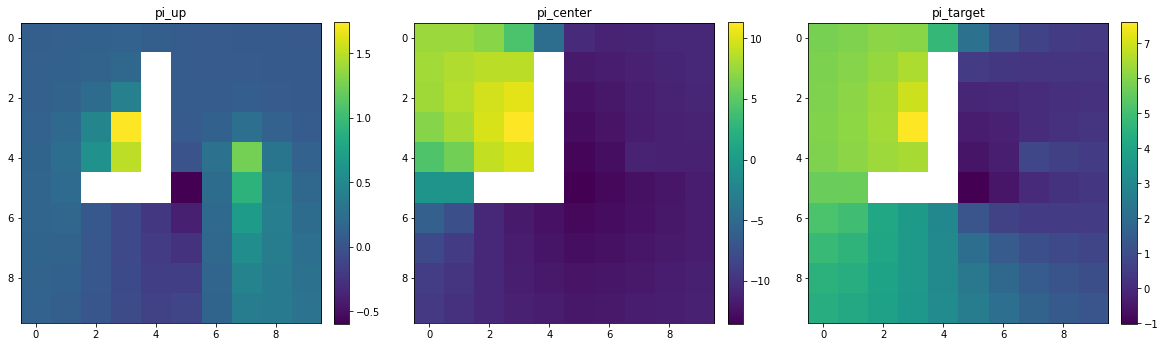

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,20))
z1 = ax1.imshow(value_up_matrix)
z2 = ax2.imshow(value_center_matrix)
z3 = ax3.imshow(value_target_matrix)
ax1.title.set_text("pi_up")
ax2.title.set_text("pi_center")
ax3.title.set_text("pi_target")
plt.colorbar(z1,ax=ax1,fraction=0.046, pad=0.04)
plt.colorbar(z2,ax=ax2,fraction=0.046, pad=0.04)
plt.colorbar(z3,ax=ax3,fraction=0.046, pad=0.04)
plt.show

# Part 2: Value Iteration and Policy Iteration

Now it's time to calculate the optimal value function and the optimal policy.

Your tasks
--
1. Implement the value iteration algorithm that takes as input (P,r,gamma), an initial estimate V of the value function, and the maximum number of iterations. The output should be the value function estimated after max_iter iterations.
2. Implement the policy iteration algorithm that takes as input (P,r,gamma), an initial estimate V of the value function, and the maximum number of iterations. The output should be the value function estimated after max_iter iterations. (You can terminate the iterations once the policy stops changing.)
3. Run the two algorithms for 10 iterations each and plot the value estimates side by side. Repeat for 100 and 1000 iterations. What do you observe?

In [12]:
### value iteration
# P: X by X by A transition matrix
# r: X-sized reward vector
# gamma: discount factor
# V: initial value-function estimate
# max_iter: number of iterations
def value_iteration(P,r,gamma,V,max_iter):
    ### YOUR CODE COMES HERE
    ### YOUR CODE ENDS HERE
    for i in range(0,max_iter):
      V_new=np.zeros((M*N))
      
      for m in range(0,X):
        v=np.zeros((4))
        
        for a in range(0,4):
          v[a]=r[m]+ gamma*(np.dot(P[m,:,a], V))
        
        V_new[m]=np.max(v)
      V=V_new
  
        

    return V

In [13]:
gamma = .99
opt_value_VI = value_iteration(P,r,gamma,np.zeros(X),1000)
opt_value_VI_matrix = vector_to_matrix(opt_value_VI,M,N)

In [25]:
### policy iteration
# P: X by X by A transition matrix
# r: X-sized reward vector
# gamma: discount factor
# V: initial value-function estimate
# max_iter: number of iterations
def policy_iteration(P,r,gamma,V,max_iter):
    ### YOUR CODE COMES HERE
    ### YOUR CODE ENDS HERE
    policy = np.zeros((M*N,4))+.5
    V_new=np.zeros((M*N))
    for i in range(0,max_iter):
      V=evaluate2(P,policy,r,gamma)
      for m in range(0,M*N):
        v=np.zeros((4))
        for a in range(0,4):
          v[a]=r[m]+gamma*(np.dot(P[m,:,a], V))
        V_new[m]=np.max(v)
      
        policy[m]=np.zeros((4))
        policy[m,np.argmax(v)]=1
      V=V_new


    return V

In [24]:
v=np.zeros((4))
for a in range(0,4):
  v[a]=a
print(np.argmax(v))

3


In [26]:
opt_value_PI = policy_iteration(P,r,gamma,np.zeros(X),max_iter=1000)
opt_value_PI_matrix = vector_to_matrix(opt_value_PI,M,N)

In [27]:
opt_value_PI


array([44.49328637, 45.10788189, 45.85175167, 46.35381671, 45.31117058,
       44.05192746, 42.88768008, 41.80314878, 40.81120169, 40.02680125,
       45.09831001, 45.79232722, 46.67740106, 47.47745314,  0.        ,
       42.88684804, 41.98216486, 41.0816102 , 40.22359792, 39.5293327 ,
       45.83776447, 46.65707317, 47.66558727, 48.70422319,  0.        ,
       41.79767744, 41.08368488, 40.2778311 , 39.51644638, 38.90231707,
       46.36288769, 47.33744114, 48.59945523, 50.02758316,  0.        ,
       40.77689304, 40.24478658, 39.66044555, 38.99086306, 38.4137627 ,
       46.01486036, 46.89946891, 48.05053853, 48.99328191,  0.        ,
       39.80462827, 39.57082624, 39.97203121, 38.98311218, 38.23839026,
       45.17206883, 45.71928201,  0.        ,  0.        ,  0.        ,
       38.67874097, 38.9007876 , 38.97429305, 38.22321364, 37.60861696,
       44.2544202 , 44.41923611, 43.24794349, 42.14320164, 41.06636572,
       39.87210819, 38.98118426, 38.26165416, 37.5628855 , 37.00

<function matplotlib.pyplot.show(*args, **kw)>

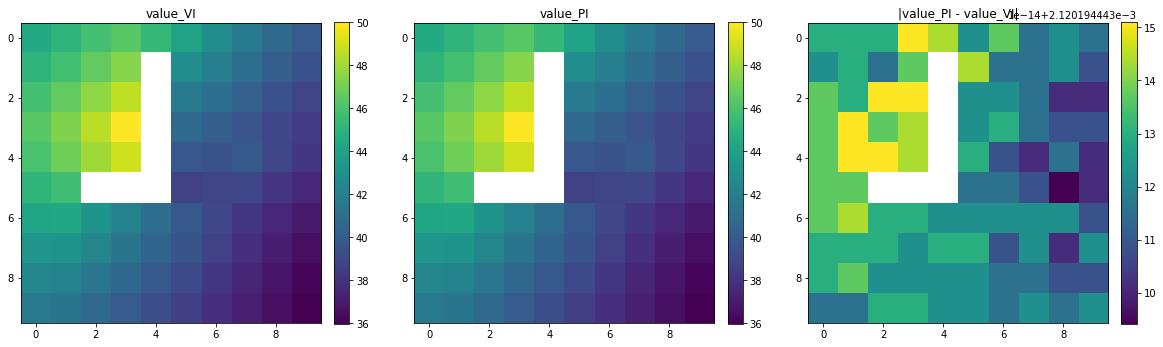

In [28]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,20))
z1 = ax1.imshow(opt_value_VI_matrix)
z2 = ax2.imshow(opt_value_PI_matrix)
z3 = ax3.imshow(np.abs(opt_value_PI_matrix - opt_value_VI_matrix))
ax1.title.set_text("value_VI")
ax2.title.set_text("value_PI")
ax3.title.set_text("|value_PI - value_VI|")
plt.colorbar(z1,ax=ax1,fraction=0.046, pad=0.04)
plt.colorbar(z2,ax=ax2,fraction=0.046, pad=0.04)
plt.colorbar(z3,ax=ax3,fraction=0.046, pad=0.04)
plt.show

# Epilogue

If time permits, you can play around with the code in a variety of ways, e.g.:
1. Change the reward function, add and remove obstacles, or change the size of the MDP.
2. Extract the optimal policy from the policy and value iteration algorithms. Does it match your intuition?
3. Plot the distance (say, in supremum norm) from the optimal value function as a function of iterations. Do the results match the predictions of theory?